# 7. Convolutional Neural Network

## 7.1. From Fully Connected Layers to Convolutions

### 7.1.1. Invariance
* 이미지에 찾고자하는 대상의 위치와 생김새는 의존적이지 않음 (what Waldo looks like does not depend upon where Waldo is located)
* CNN은 'spatial invariance'(공간적 불변성)의 아이디어에서 시작해 적은 parameter를 이용해 학습할 수 있음

* To guide our design of a NN suitable for CV  
    1. Translation Invarience - 초기 계층에서 이미지 상 위치와 상관 없이 동일한 patch에 대해 비슷한 응답을 주어야 함  
    2. Locality Principle - 초기 계층에서 국소적인 영역에 집중해야 함 > 전체 이미지 수준의 예측을 위해 통합 될 수도 있음  
    3. Capture longer-range feature - 계층이 깊어짐에 따라 longer-range feature를 포착할 수 있어야 함(like higher level vision in nature)  

### 7.1.2. Constraining the MLP
* MLP with 2-Dim images $\mathbf{X}$ as input & immediate hidden representations $\mathbf{H}$ similarly represented as matrices
* let $[\mathbf{X}]_{i, j}$ and $[\mathbf{H}]_{i, j}$ denote the pixel at $(i, j)$
* parameters as fourth-order weight tensors $\mathbf{W}$ for each of hidden units recieve from each input pixels > MLP에서 사용한 가중치 행렬이 아닌 가중치 텐서로 표현됨 (2차원이 아닌 4차원인 이유는 채널 고려 필요)  
* biases $U$
* fully connected layer  
    $[\mathbf{H}]_{i, j} = [\mathbf{U}]_{i, j} + \sum\limits_{k}\sum\limits_{l}[\mathbf{W}]_{i, j, k, l}[\mathbf{X}]_{k, l} \\ 
    = [\mathbf{U}]_{i, j} + \sum\limits_{a}\sum\limits_{b}[\mathbf{V}]_{i, j, a, b}[\mathbf{X}]_{i+a, j+b}.$
* W -> V 는 동일 k, l을 re-index한 것임 (a, b, 라는 offset 이용) ? hidden representation $[\mathbf{H}]_{i, j}$를 계산할 때 이를 둘러싼 픽셀들을 이용하므로 re-index된 표현이 훨씬 유리
* 만약 1000 * 1000 image(1 megapixel)라면 single layer를 구성하는데 있어 이미지를 1000 * 1000 hidden representation에 매핑하므로 10^12개의 parameter를 요함

#### 7.1.2.1. Translation Invariance
* invoke first principle : shift in the input $\mathbf{X}$ should lead to a shift in hidden representation $\mathbf{H}$ (input의 변화가 hidden repersentation에 반영되어야 함)
* only possible if V and U do not depend on (i, j) -> $[\mathbf{V}]_{i,j,a,b} = [\mathbf{V}]_{a, b}$ & $\mathbf{U}$ is constant, $u$
* Simplify $\mathbf{H}$ : $[\mathbf{H}]_{i, j} = u + \sum\limits_{a}\sum\limits_{b}[\mathbf{V}]_{a, b}[\mathbf{X}]_{i+a, j+b}.$
* "Convolutuon"임. (i, j) 주변의 (i+a, j+b)에 위치한 픽셀들의 가중치를 V_ab를 이용해 구할 수 있음
* 해당 과정을 통해 파라미터를 4*10^6개로 줄일 수 있음

#### 7.1.2.2. Locality
* invoke second principle : (i, j)로부터 너무 멀리 떨어진 픽셀까지 볼 필요가 없음 즉, a와 b의 범위를 $\Delta$로 줄일 수 있음 (a or b가 $\Delta$ 이상이라면 V_ab = 0)
* $\mathbf{H}$ : $[\mathbf{H}]_{i, j} = u + \sum\limits_{a=-\Delta}^{\Delta}\sum\limits_{b=-\Delta}^{\Delta}[\mathbf{V}]_{a, b}[\mathbf{X}]_{i+a, j+b}.$
* parameter를 $4\Delta^2$으로 줄일 수 있고, 일반적으로 $\Delta$ 값은 10 이하로 잡는다
* 해당 수식은 Convolutional Layer라고 부를 수 있고, CNN은 해당 계층을 포함하는 NN
* $\mathbf{V}$의 경우 convolution kernel, filter, layer's weight 등으로 불리며 학습가능한 매개변수임
* 이런 과정을 통해 input/hidden representation의 dim을 바꾸지 않고 parameter를 몇 백개로 줄일 수 있음 but, parameter가 줄었기 때문에 feature가 translation invariance를 갖고 hidden representation을 결정할 때 local information만을 통합할 수 있음  
    즉, translation invariance와 locality라는 귀납적 편향(inductive bias)를 가지게 되며, 해당 편향과 벗어날 경우 acc 매우 낮아질 수 있음
* 더 깊은 층의 경우 이미지의 크고 복잡한 측면을 표현해야 하는데, 이는 nonlinearity(active function 등)와 convolutional layer를 반복적으로 교차시켜 사용할 수 있음

### 7.1.3. Convolutions
* $[\mathbf{H}]_{i, j} = u + \sum\limits_{a=-\Delta}^{\Delta}\sum\limits_{b=-\Delta}^{\Delta}[\mathbf{V}]_{a, b}[\mathbf{X}]_{i+a, j+b}.$ 해당 수식의 수학적 접근
* in mathematics, convolution between two functions? $f, g : \mathbb{R}^d \rightarrow \mathbb{R} , (f*g)(\mathbf{x}) = \int f(\mathbf{z})g(\mathbf{x-z})d\mathbf{z}$ 
* 즉, 한 함수가 뒤집(flipped)히고 x에 대해 옮겨(shifted)질 때 f와 g 사이의 overlap을 측정하는 것 

### 7.1.4. Channels
* image는 RGB 3개의 channel로 구성 돼 있음 -> image is not 2-Dim objects but thrid-order tensors (height, width, channel)
* 역시 hidden repersentation H 또한 thrid-order tensor로 바꾸어 생각해야 함  
General def of convolutional layer: $[\mathbf{H}]_{i, j, d} = \sum\limits_{a=-\Delta}^{\Delta}\sum\limits_{b=-\Delta}^{\Delta}\sum\limits_{c}[\mathbf{V}]_{a, b, c, d}[\mathbf{X}]_{i+a, j+b,c}.$ 이때 d는 output channel in hidden rep.

### 7.1.5. Summary
* Translation Invariance / Locality 중요한 개념이고 매개변수를 줄이는 핵심이자 해당 가정들 하에서 적절한 학습 가능
* Channel을 통해 복잡성을 회복


## 7.2. Convolutions for Images

In [40]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation
* input tensor와 kernel tensor는 output tensor를 위해 cross-correlation 연산을 거침
* 따라서 3*3 입력과 2*2 필터(커널)를 적용시키면 2*2 결과를 얻을 수 있음  

0/1/2  ...     0/1  ...   19/25  
3/4/5  ...     2/3  ...   37/43  
6/7/8 
19 = 0 * 0 + 1 * 1 + 3 * 2 + 4 * 3  

* input size ($n_h \times n_w$), kernel size ($k_h \times k_w$) 일 때, output size $(n_h - k_h + 1)\times(n_w-k_w+1)$ when kernel fits wholly within the image (kernel이 이미지 내부에 완전히 맞을 때만 cross correlation 계산 가능)

In [2]:
def corr2d(X, K):
    """Compute 2D cross-correlation"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i : i + h, j : j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolutional Layers
* convolutional layer cross-correlates the input and kernel and adds scalar bias to produce an output

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3. Object Edge Detection in Images
* detecting the edge of an object by finding the location of pixel change
* construct  6*8 pixel image, middle 4 columns are black(0) others are white(1)

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

to find a change, use [1, -1] ? white to black = 1, black to white = -1, others = 0

In [6]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

apply kernel to transposed image? it vanishes ... kernel K only detects vertical edges

In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel
* finite differences([1, -1])로 kernel을 설정하는 것은 찾고자 하는 것을 명확하게 알고 있는 경우 유용 but larger kernel 혹은 successivw layers of convolutions?
* 입출력 쌍(X-Y)을 통해 kernel을 학습
* Convolutional layer를 구성한 다음 random tensor로 kernel을 초기화, 이후 iteration에서 계산 값과 Y를 비교해 squared error 도출  
해당 squared error 이용해 kernel을 업데이트 하기 위한 gradient 계산 할 수 있다.

In [9]:
# Construct a two-dim convolutional layer with 1 output channel and a kernel of shape (1, 2). ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dim convolutional layer uses four-dim input and output in the format of (example, channel, height, width)
# where the batch size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 12.364
epoch 4, loss 3.207
epoch 6, loss 1.002
epoch 8, loss 0.358
epoch 10, loss 0.138


/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


10회 정도 반복 후 loss(error)가 꽤 떨어진 것을 확인할 수 있음, 이때 학습된 kernel tensor?

In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0231, -0.9481]])

### 7.2.5. Cross-Correlation and Convolution
* 만약 Cross-Correlation이 아닌 7.1.에서 정의한 convolution operation을 이용하려면? two-dim kernel의 가로, 세로를 각각 뒤집으면 됨
* Cross-Correlation과 Convolution이 다르기 때문이며, 상관 연산은 입력과 커널을 곱하고 더하는 것으로 가능하나 합성곱은 커널을 뒤집은 뒤 곱하고 더하는 과정을 거치기 때문
* 사실 학습을 통해 kernel이 계산되기 때문에 어떤 연산을 이용하더라도 convolutional layer의 output에는 큰 상관은 없음

### 7.2.6. Feature Map and Receptive Field
* feature map: convolution layer's output / receptive field(수용 영역): foward propagation에 있어 x의 계산에 영향을 줄 수 있는 모든 이전 층의 요소 즉, x가 처리하는 입력 데이터의 범위
* receptive field는 실제 입력 크기보다 클 수 있고 이는 깊어질수록 상위층이 더 넓은 receptive field를 가지며 더 복잡한 패턴에 대한 학습이 가능하게 도와줌

### 7.2.7. Summary
* Cross-correlation이 convolutional layer의 핵심 연산이며 간단하게 계산될 수 있음, 만약 입력 채널과 출력 채널이 여러 개 있는 경우 행렬 연산 수행할 수 있음

## 7.3. Padding and Stride
기존의 방식으로 convolution을 진행할 경우, output이 반드시 줄어듦 > layer를 거쳐감에 따라 data의 손실이 발생함

### 7.3.1. Padding
* 꼭짓점에 위치한 픽셀일수록 convolution 과정에 덜 사용됨
* 만약 주변에 임의의 블럭을 배치한다면? 즉, 여유 공간을 만들 수 있다면 데이터가 줄어드는 문제와 꼭짓점에 위치한 데이터들의 이용 빈도를 늘릴 수 있음


In [11]:
# helper function to calculate convolutions
# initialize the convolutional layer weights and performs corresponding dimensionality elevations
# and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [12]:
# We use a convolution kernel with height 5 and width 3
# padding either side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

즉, kernel size를 이용해 k-1 / 2 만큼의 행(열)을 추가하여 convolution을 하지만 크기가 줄어들지 않게 설정할 수 있음

### 7.3.2. Stride
* 한 slide에 대해 kernel을 적용시킬 간격
* output shape = $\lfloor(n_h - k_h + p_h + s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor$

In [13]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [14]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

* padding? Increase height / weight of output ... often used to avoid undesirable shrinkage of output
* stride? Can reduce the resolution of output
* default padding = 0 / stride= 1

## 7.4. Multiple Input and Multiple Output Channels

### 7.4.1. Multiple Input Channels
* input data가 multiple channels을 가진다면, convolution kernel 역시 같은 수의 channel을 가져야 함
* channel의 수가 1이라면 단순히 2-dim tensor를 생각할 수 있고, 여러개의 channel을 가질 경우 각 channel에서 convolution 한 뒤 합하는 구조로 생각할 수 있음

In [15]:
import torch
from d2l import torch as d2l

In [16]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [17]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels
* 실제로는 각 층의 결과 값이 다중 채널을 갖는 것이 유리 > 서로 다른 feature에 대해 반응하기 위해
* 여러 채널을 갖지만 실제로는 이들이 같이 유동하도록 최적화됨(optimized to be jointly useful) > 서로 상호작용함

In [18]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform cross-correlation operations with input X.
    # All of the results are stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [19]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [20]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3. $1\times1$ Convolutional Layer
* 1 by 1 kernel을 이용하는 경우, 의미가 없어보이기도 하지만 실제로 많이 사용되는 연산임
* 가장 작은 크기의 window 사용하기에 인접한 요소들 간의 상호작용하는 패턴을 인식할 수는 없으나, 채널 차원에서 특정 맵 채널 사이의 정보를 통합하거나 변경하는데 이용됨
* 즉, 차원 축소 혹은 비선형 변환 등에 이용되며 채널 간 상관 관계를 학습할 수 있음

In [21]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [22]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5. Pooling
* migrating the sensitivity of convolutional layers to location and downsampling repersentations
* 즉, 위치 변화에 덜 민감하며 repersentation의 크기를 줄이되 최대한 정보를 유지하는 과정

### 7.5.1. Maximum Pooling and Average Pooling
* pooling area에 속한 데이터들의 최대값으로 pooling / 평균값으로 pooling
* average pooling 의 경우 인접한 픽셀들을 평균냄으로써 signal-to-noise ratio에서 유리함 (안정적인 값을 가질 수 있음)
* maximum pooling 의 경우 최대값(가장 중요한 feature)를 선택하기에 노이즈를 줄이는 동시에 중요한 정보를 강조하기에 주로 사용됨



In [23]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [24]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [25]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride
pooling도 shape of output을 변화시키는 연산이므로 padding 과 stride를 이용해 출력의 형태를 원하는 모습으로 바꿀 수 있음

In [26]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [27]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [28]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [29]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

위의 예시와 같이 특정 행, 열에 작동할 방식 설정할 수도 있음

### 7.5.3. Multiple Channels

In [30]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

2개의 input에 대해 수행한 결과, output 역시 2개의 channel을 가짐을 확인할 수 있음

## 7.6. Convolutional Neural Networks (LeNet)
### 7.6.1. LeNet
* 크게 2 부분으로 구성 가능  
    (1) convolutional encoder constisting of two convolutional layers  
    (2) dense block consisting of three fc layer

![LeNet](/Users/shinbeomjoon/Documents/COSE474_DeepLearning/hw2/lenet.svg)

In [32]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

* Network 내부에서?  
Single Channel (Black/White) 28 $\times$ 28 image  
flow: Image(28*28) $\rightarrow$ 5 $\times$ 5 Conv (6), pad 2 $\rightarrow$ 2 $\times$ 2 AvgPool, stride 2 $\rightarrow$ 5 $\times$ 5 Conv (16) $\rightarrow$ 2 $\times$ 2 AvgPool, stride 2 $\rightarrow$ FC (120) $\rightarrow$ FC (84) $\rightarrow$ FC (10) 

In [33]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training ...with Fashion MNIST  
d2l.Trainer에 의해서 학습하긴 하지만 기본적으로는 loss function은 cross-entropy를 이용하며 이를 minibatch stochastic gradient descent 이용해 minimize 함

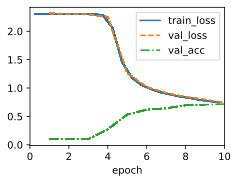

In [34]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

CNN이 MLP보다 적은 파라미터를 이용하지만 파라미터를 구하는데 있어 계산 양의 차이 때문에 시간이 오래 걸림  
단순하게는 GPU 접근하는 방식으로 시간 줄일 수 있음

# 8. Modern Convolutional Neural Networks

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
print(torch.backends.mps.is_available())

True


## 8.2. Networks Using Blocks (VGG)

AlexNet을 통해 deep CNN 이 좋은 결과를 낼 수 있음을 확인 but 일반적인 틀을 주지는 못 함
* 심층 네트워크를 위한 몇 가지 heuristic concepts ... 그 중 하나가 "block"


### 8.2.1. VGG Blocks
    (i) Convolutional layer with padding to maintain the resolution  
    (ii) nonlinearity like ReLU  
    (iii) Pooling layer to reduce the resolution
* Spatial resolution decrease quit rapidly -> d-Dim 사용한다 할 때 convolutional layer의 수가 $\log_2d$로 제한 됨

* VGG Block의 경우, sequence of convolution of 3 $\times$ 3 kernels with padding 1 (keeping height & width) followed by 2 $\times$ 2 max-pooling layer with stride 2 (halving height and width after each block)

In [12]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 8.2.2. VGG Network
기존 각각의 연산(Conv, Pooling 등)이 개별적으로 구성되던 AlexNet 과 달리 VGG의 경우 block 단위로 구성 돼 있음

In [13]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:  # Conv와 Pooling이 묶인 block 단위로
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

원래 VGG Network은 5개 Conv Block 가지고 있으며 첫 두 블럭은 각각 1개의 Conv layer를, 나머지 세 블럭은 각각 2개의 Conv layer를 가짐  
첫 블럭은 64개의 output channel, 각 블럭이 512 도달 할 때 까지 출력 채널의 수를 2배수로 증가시킴  
* 총 8개의 Conv Layer와 3개의 FC Layer 사용하기 때문에, 'VGG-11'

In [14]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3. Training


In [53]:
device = torch.device("mps")

In [17]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
#model.to(device)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
model.to(device)
#trainer.fit(model, data)

def train_model(model, data, trainer, device):
    model.train()  # 학습 모드로 설정

    # DataLoader 가져오기
    train_loader = data.get_dataloader(train=True)
    test_loader = data.get_dataloader(train=False)

    # 손실 함수 및 옵티마이저 설정
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # 에포크별 학습 루프
    for epoch in range(trainer.max_epochs):
        for X, y in train_loader:
            # 데이터를 GPU로 이동
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # Backward pass 및 옵티마이저 스텝
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

train_model(model, data, trainer, device)

Epoch 1, Loss: 2.304579496383667
Epoch 2, Loss: 2.3103199005126953


KeyboardInterrupt: 

* CPU로 작동 했는데 device GPU로 바꿀 방법 찾아서 다시 적용해보기
* Colab 으로 실행한 결과 첨부

## 8.6. Residual Networks (ResNet) and ResNeXt

8.6.1. ~ 8.6.4


In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1. Function Classes
* $\mathcal{F}$, class of functions that a specific network architecture can reach
* for all $f \in \mathcal{F}$, there exist some set of parameters
* let $f^*$ is the truth function that we want to find, feature $\mathbf{X}$ and label $\mathbf{y}$ optimization:  
    $f^*_{\mathcal{F}} \overset{\mathrm{def}}{=} \underset{f}{\arg\min L}(\mathbf{X, y}, f) \operatorname{subject\,to} f \in \mathcal{F}.$
* 이때, $\mathcal{F}$를 정규화시킨다면 데이터가 더 클 수록 더 나은 함수 $f^*$를 찾을 수 있다  
    but 항상 성립하는 것은 아님. 만약 $\mathcal{F}$가 Non-nested 되었다면 특정 $\mathcal{F}_n$에 대해 $f^*$가 더 가까운 경우를 볼 수 있음
* 즉, 더 큰 function class가 더 작은 function class를 포함하는 경우에만 클래스의 크기를 늘림에 따라 표현력이 증가한다고 보장할 수 있다.  
여기서 새로운 층을 identity function(f(x) = x)을 이용해 학습시킬 수 있다면 추가된 층이 아무 영향을 주지 않게 학습될 수 있음을 의미



### 8.6.2. Residual Blocks
![residual-block](/Users/shinbeomjoon/Documents/COSE474_DeepLearning/hw2/residual-block.svg)

* 왼쪽의 경우 block이 직접적으로 f(x) 학습
* 오른쪽의 경우 box 내부에 있는 부분이 residual mapping , g(x) = f(x) - x 를 학습함  
x를 전달해주는 실선을 residual(shortcut) connection이라 부름

만약에 f(x) = x 라면 g(x) = 0이 되기에 학습하기 더 쉬워짐 > convolutional Layer의 weight이나 bais를 0으로 만들어주면 됨  


ResNet은 VGG의 full 3 $\times$ 3 convolutional layer design 가지고 있음. Residual block은 output channel의 수와 같은 두 3 by 3 convolution layer를 가짐  
만약 channel을 바꾸고 싶다? 1 $\times$ 1 convolutional layer 추가

In [19]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

use_1x1conv 값에 따라 두 가지 형태의 network을 만들 수 있다

In [20]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

halve the out put's height and width by setting stride

In [21]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

7 * 7 convolutional layer with 64 output channels, stride 2 is followed by the 3 * 3 max pooling with stride 2  
체크할 점은 normalization layer가 추가됨  

아래는 ResNet-18의 구조  
![resnet18-90](/Users/shinbeomjoon/Documents/COSE474_DeepLearning/hw2/resnet18-90.svg)

In [22]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [23]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [24]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [25]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

KeyboardInterrupt: 

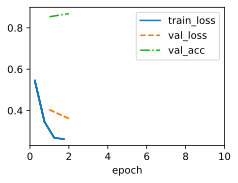

In [26]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)